### Notebook to test the Wine Contest

Carlos H Grohmann
2022

In [8]:
# imports
import sys,os
from ipywidgets import Button
from tkinter import Tk, filedialog
from IPython.display import clear_output, display
import qgrid

import pandas as pd
import numpy as np
from scipy.special import ndtri
import seaborn as sns



# aux funcs
def qshow(df):
    '''show df witrh qgrid and predefined options'''
    grd = qgrid.show_grid(df, grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})
    return grd

# from: https://edusecrets.com/lesson-02-creating-a-file-select-button-in-jupyter-notebook/
def select_files(b):
    clear_output()
    root = Tk()
    root.withdraw() # Hide the main window.
    root.call('wm', 'attributes', '.', '-topmost', True) # Raise the root to the top of all windows.
    b.files = filedialog.askopenfilename(multiple=True) # List of selected files will be set button's file attribute.
#     b.names = [f.split('/')[-1].split('.')[0] for f in b.files] # only names of files
    names = [f.split('/')[-1] for f in b.files]
    print(f'Selected files:{str(names)[1:-1]}') # Print the list of files selected.

open_csv_files = Button(description="Select CSV file(s)")
open_csv_files.on_click(select_files)

### Open CSV file(s)

In [9]:
# open csv files with tk dialog
open_csv_files

Button(description='Select CSV file(s)', style=ButtonStyle())

In [3]:
# make dataframes from csv files and append all to a single one
df_csv = pd.DataFrame()
for f in open_csv_files.files:
    df = pd.read_csv(f, sep=',',engine='python',comment='#',quotechar='"')
    df_csv = pd.concat([df_csv,df],sort=False)
    
# get lists with DEMs names and criteria
crit_cols = list(df_csv.columns)[5:]
crit_cols_rank = [i+'_rank' for i in crit_cols]
crit_cols_rank_sq = [i+'_rank_sq' for i in crit_cols]
dem_cols = list(df_csv['DEM'].unique())


# rank values in df
df_ranks = pd.concat([df_csv, df_csv.groupby('DEMIX_TILE').rank(method='average', ascending=True, axis=1).add_suffix('_rank')], axis=1)
for col in crit_cols:
    df_ranks[col+'_rank_sq'] = df_ranks[col+'_rank']**2


print(f'DEMs being compared: {dem_cols}\n')
print(f'Criteria: {crit_cols}')

# show table 
qshow(df_ranks)

DEMs being compared: ['COP', 'SRTM_egm2008', 'ALOS_egm2008', 'NASA_egm2008', 'ASTER_egm2008', 'FABDEM']

Criteria: ['GRID_FULL', 'DIFF_MIN', 'DIFF_Max', 'DIFF_Mean', 'DIFF_STDEV', 'DIFF_SKEW', 'DIFF_KURT', 'DIFF_MED', 'N']


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

### First to compute: Friedman Test Statistic's

*Null hypothesis: there exist no statistically significant difference among the DEMs*  

Friedman Test using formula from:https://jimgrange.wordpress.com/2014/05/29/friedmans-test-with-tied-data/ 

where n is the number of observations per condition, k is the number of conditions, and Ri is the sum of the ith column (condition).

Friedman Statistic's  
n(k-1)[sum Ri_sq/n - cf] / sum rij_sq - cf  
cf = (1/4)nk(k+1)**2

In [4]:
n = len(dem_cols) # number of DEMs
k = len(crit_cols) # number of CRITERIA
cf = 1/4*n*k*((k+1)**2)

sum_ranks = df_ranks[crit_cols_rank].sum().sum()
sum_ranks_sq = df_ranks[crit_cols_rank_sq].sum().sum()

chi_r =( (n * (k-1)) * (sum_ranks_sq/n - cf) )/ (sum_ranks - cf)

print(f'n = {n} (number of DEMs)')
print(f'k = {k} (number of Criteria)')
print(f'cf = {cf}')
print(f'sum of ranks = {sum_ranks}')
print(f'sum of ranks squared = {sum_ranks_sq}')
print(f'chi_r = {chi_r:4.3f}')

n = 6 (number of DEMs)
k = 9 (number of Criteria)
cf = 1350.0
sum of ranks = 3753.0
sum of ranks squared = 26331.5
chi_r = 60.696


#### Get critical value from tables

Given your k value, look for the proper table at:   http://hdl.handle.net/20.500.11968/4208  
From the table, look at the row at your N and read the entry at your preferred confidence level  
if chi_r>chi_crit, we must reject the null hipothesis and go the the Post-Hoc analysis below  
(Reject means that we cannot accept that all DEM are equivalent)  
If chi_r<chi_crit, we cannot disprove the null hipothesis at the given CL and the test finishes

In [5]:
CL = 0.05

tables_dir = 'Friedmans_tables'
# os.listdir(tables_dir)
table_needed = f'k_{k}.txt'
# print(f'Table needed: {table_needed}')
df_crit = pd.read_csv(os.path.join(tables_dir,table_needed),sep=';')
df_crit = df_crit.iloc[: , :-1] # drop last column as it is empty
df_crit

# find chi_crit in table
n_alpha = f'N={n}' 
idx = df_crit.loc[df_crit['alpha'] == n_alpha].index[0]
col = f'{CL:05.3f}'

# try to get the value, if not possible, use last row IS THIS CORRECT??
try:
    chi_crit = df_crit.at[idx, col]
except:
    idx = df_crit.index[-1]
    chi_crit = df_crit.at[idx, col]
    
print(f'For k={k}, CL={CL}, and N={n}, the critical value to compare is chi_crit={chi_crit}')
print()
print(f'chi_r: {chi_r:04.3f}')
print(f'chi_crit: {chi_crit}\n')

if chi_r > chi_crit:
    print('Yay!! We can reject the null hipothesis and go to the Post-Hoc analysis!!')
else:
    print('Oh, no! We  we cannot disprove the null hipothesis at the given CL...')

For k=9, CL=0.05, and N=6, the critical value to compare is chi_crit=14.739

chi_r: 60.696
chi_crit: 14.739

Yay!! We can reject the null hipothesis and go to the Post-Hoc analysis!!


### DEMs Ranked

In [6]:
# DEMs ranked
pd_ranked = pd.DataFrame()
dems_ranked = df_ranks.groupby('DEM')[crit_cols_rank].sum().sum(axis=1)
pd_ranked['rank_sum'] = dems_ranked
pd_ranked['final_rank'] = pd_ranked['rank_sum'].rank(ascending=1)
# pd_ranked = pd_ranked.set_index('final_rank').sort_index()
print(pd_ranked.sort_values(by='final_rank'))

               rank_sum  final_rank
DEM                                
NASA_egm2008      529.0         1.0
FABDEM            610.0         2.0
ALOS_egm2008      633.5         3.0
SRTM_egm2008      650.0         4.0
COP               657.0         5.0
ASTER_egm2008     673.5         6.0


### Post-Hoc Analysis
#### As a quick-and-dirty option, we illustrate the procedure with Bonferroni-Dunn test

Note: Bonferroni-Dunn test is not state of the art  

About the table below:  
"Y" means that the difference is significative to the 95%  
“N” means that we cannot demonstrate a statistically significative difference  
The test is pairwise (DEM-i vs. DEM-j), so by symmetry we disregard the lower part of the matrix  

In [7]:
alpha_bd = 0.95
quant =  1-alpha_bd/k/(k-1)
zi = ndtri(quant)
crit = zi*np.sqrt(n*k*(k+1)/6) # why divide by 6? is this k?

# print(f'quant: {quant:3.4f}')
# print(f'zi: {zi:3.4f}')
# print(f'crit: {crit:3.4f}')

# create table
cols = ['DEM'] + dem_cols
df_table = pd.DataFrame(columns=cols)
df_table['DEM'] = dem_cols

# get ranks values 
ranks_vals = dems_ranked.to_frame().T

# print(df_table)
print()
print(ranks_vals)

# populate table
for d1 in dem_cols:
    r = dem_cols.index(d1)
    for d2 in dem_cols:
        rank_dem1 = ranks_vals[d1].values[0]
        rank_dem2 = ranks_vals[d2].values[0]
#         print(d1,d2,rank_dem1,rank_dem2)
        if np.abs(rank_dem1 - rank_dem2) > crit:
            df_table.at[r,d2] = 'WIN'
        else:
            df_table.at[r,d2] = 'LOOSE'
            
# use numpy to get only the upper triangle of the table 
m = np.triu(df_table.values,k=1)
# m[np.tril_indices(m.shape[0], 1)] = np.nan
df2 = pd.DataFrame(m,columns=cols)
df2['DEM'] = dem_cols
df2
# df2.drop(columns='dem',inplace=True)
# df2.style.applymap(lambda v: 'opacity: 20%;' if pd.isnull(v) else None)
df2.style.applymap(lambda v: 'opacity: 20%;' if (v==0) else None)


DEM  ALOS_egm2008  ASTER_egm2008    COP  FABDEM  NASA_egm2008  SRTM_egm2008
0           633.5          673.5  657.0   610.0         529.0         650.0


,DEM,COP,SRTM_egm2008,ALOS_egm2008,NASA_egm2008,ASTER_egm2008,FABDEM
0,COP,LOOSE,LOOSE,WIN,WIN,LOOSE,WIN
1,SRTM_egm2008,0,LOOSE,LOOSE,WIN,WIN,WIN
2,ALOS_egm2008,0,0,LOOSE,WIN,WIN,WIN
3,NASA_egm2008,0,0,0,LOOSE,WIN,WIN
4,ASTER_egm2008,0,0,0,0,LOOSE,WIN
5,FABDEM,0,0,0,0,0,LOOSE


### Plotting

In [57]:
print(f'Criteria: {crit_cols}')

Criteria: ['GRID_FULL', 'ELD_MIN', 'ELD_Max', 'ELD_Mean', 'ELD_AVG', 'ELD_STD', 'ELD_MEDIAN', 'ELD_RMSE', 'ELD_MAE', 'ELD_AB_MD', 'N']


In [58]:
df_csv.describe()

,GRID_FULL,ELD_MIN,ELD_Max,ELD_Mean,ELD_AVG,ELD_STD,ELD_MEDIAN,ELD_RMSE,ELD_MAE,ELD_AB_MD,N
count,78.000000,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,78.000000,7.800000e+01,7.800000e+01,78.000000,78.000000
mean,92.322308,-2.366074e+34,5.083384e+32,-1.364500e+29,2.784070e+29,5.569374e+31,4.939872,5.569376e+31,1.419600e+29,6.768333,207030.679487
std,7.922213,1.194859e+35,1.772334e+33,7.025666e+29,1.418190e+30,2.826297e+32,4.667955,2.826298e+32,7.157077e+29,4.660422,69311.763098
min,77.050000,-1.000000e+36,2.007000e+01,-5.915124e+30,6.800000e-01,1.410000e+00,-3.330000,1.540000e+00,9.300000e-01,0.530000,83540.000000
25%,87.180000,-2.022800e+02,8.732000e+01,1.507500e+00,4.550000e+00,6.365000e+00,0.530000,8.110000e+00,5.447500e+00,1.820000,147341.250000
50%,91.080000,-1.044300e+02,2.192500e+02,5.750000e+00,8.760000e+00,1.420000e+01,4.510000,1.521000e+01,1.108500e+01,6.700000,184444.500000
75%,100.000000,-5.107000e+01,3.333800e+02,1.150000e+01,1.604000e+01,2.413000e+01,8.852500,2.741000e+01,1.756250e+01,10.165000,238406.000000
max,100.000000,-1.667000e+01,6.608402e+33,1.884000e+01,1.190167e+31,2.369073e+33,14.100000,2.369074e+33,5.986677e+30,16.280000,347017.000000


array([[<AxesSubplot:title={'center':'GRID_FULL'}>,
        <AxesSubplot:title={'center':'ELD_MIN'}>,
        <AxesSubplot:title={'center':'ELD_Max'}>],
       [<AxesSubplot:title={'center':'ELD_Mean'}>,
        <AxesSubplot:title={'center':'ELD_AVG'}>,
        <AxesSubplot:title={'center':'ELD_STD'}>],
       [<AxesSubplot:title={'center':'ELD_MEDIAN'}>,
        <AxesSubplot:title={'center':'ELD_RMSE'}>,
        <AxesSubplot:title={'center':'ELD_MAE'}>],
       [<AxesSubplot:title={'center':'ELD_AB_MD'}>,
        <AxesSubplot:title={'center':'N'}>, <AxesSubplot:>]], dtype=object)

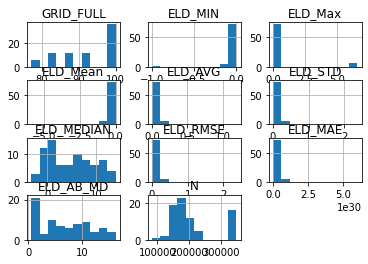

In [59]:
df_csv.hist()

<AxesSubplot:>

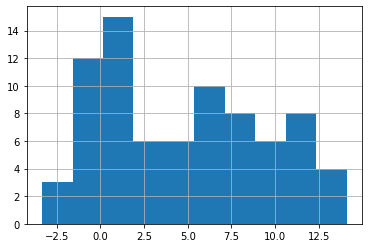

In [60]:
df_csv['ELD_MEDIAN'].hist()